### This notebook aims to numerically mimic the QPT process for a few-qubit-quantum-gate based on the qiskit simulator, where the realistic noise and error are taken into account.

Notes:  1.QPT for the one-qubit channel costs a few seconds on a laptop; less than 2 minutes for 2-q channel; more then ten hours for 3-q channel.
2. the initial states and rotations setup in QTP.py should be consistant with experiments (numerics ).


In [27]:
#====================some useful functions==========================

from QPT import QPT
from QPT import *
from numExp_qiskit import NumExp
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import itertools, random
from qutip import Qobj
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qiskit.quantum_info import random_unitary, Operator, average_gate_fidelity, Kraus, Chi, Choi
from scipy.linalg import sqrtm
from functions import *

def generate_valid_cptp_kraus_operators(n_qubits, num_kraus):
    """
    Generate a set of Kraus operators that satisfy the CPTP condition, ensuring ∑ K_i† K_i = I.

    Parameters:
    - n_qubits (int): Number of qubits
    - num_kraus (int): Number of Kraus operators to generate

    Returns:
    - list of numpy.ndarray: List of Kraus operators
    """
    # Define Pauli matrices for single qubits
    pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
    
    # Generate the tensor product of Pauli matrices for all possible combinations of qubits
    Elist = [tensor(*op).full() for op in itertools.product(pauli, repeat=n_qubits)]
    
    # Create Kraus operators by summing weighted Pauli matrices
    kraus_ops = [
        np.sum([(np.random.randn() + 1j * np.random.randn()) * E for E in Elist], axis=0)
        for _ in range(num_kraus)
    ]
    
    # Ensure the CPTP condition: ∑ K_i† K_i = I
    sum_kdag_k = sum(K.conj().T @ K for K in kraus_ops)
    sqrt_inv = np.linalg.inv(sqrtm(sum_kdag_k))
    
    # Normalize the Kraus operators to satisfy CPTP
    kraus_ops = [K @ sqrt_inv for K in kraus_ops]
    
    # Verify the CPTP condition again
    sum_kraus = sum(K.conj().T @ K for K in kraus_ops)
    
    if not np.allclose(sum_kraus, np.eye(2**n_qubits), rtol=1e-5):
        raise ValueError("The generated Kraus operators do not satisfy the CPTP condition!")
    
    # If only one Kraus operator is requested, generate a random unitary operator
    if num_kraus == 1:
        kraus_ops = [rand_unitary(2 ** n_qubits).full()]
    
    return kraus_ops

def get_chiF(chi1, chi2):
    """Calculate the fidelity between two quantum processes represented by χ matrices."""
    sqrt_chi1 = sqrtm(chi1)
    return np.real(np.trace(sqrtm(sqrt_chi1 @ chi2 @ sqrt_chi1))**2)


def get_exp_plot(measure_data,N):
  
    '''
    Visualizing the measurement data for a N-qubit gate (only for 1-q gate)
    '''

    if N<2:
        rotation = ["I", "ry(90)", 'rx(90)']
        initial_state =['|0>','|+>','|->','|1>']
        observables =['|0><0|','|1><1|']
        cir_lab = list(product(initial_state,rotation))
        
        z = measure_data  
        th = 0
        ylabel = []
        plt.figure()
        fig, ax = plt.subplots(figsize=(4,8))
        ax.imshow(z)
        ax.set_xticks(np.arange(len(observables)), labels=observables)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        for j in range(len(z)):
            for k in range(len(z[0])):
                text = ax.text(k,th, round(z[th,k], 3), ha="center", va="center", color="w")
            th+=1
            ylabel.append(cir_lab[j][0]+','+cir_lab[j][1])
        ax.set_yticks(np.arange(len(ylabel)), labels=ylabel)
        plt.show()
    else:
        print('It is only for N=1')
 



In [14]:
np.random.normal(loc=1, scale=0.2, size=1)[0]

1.1859899447455833

### The measurement data for a complete QPT of N-qubit quantum process

Example 1: the identity channel

p_reset: 0.0003084466217689501 p_meas: 0.0006915533782310499 p_unitary: 0.001
(12, 2)


<Figure size 640x480 with 0 Axes>

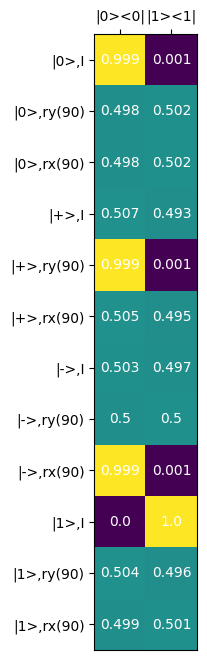

In [28]:
"""
Parameters:
- N (int): Number of qubits
- p_reset (float): State preparation (SP) error
- p_meas (float): Measurement (M) error
- random_channel (list, optional): Random quantum channel
- num_kraus (int): the number of Kraus operator
"""

# Obtain the measurement data for a randomly sampled quantum channel
N, p_tot,num_kraus = 1, 0.001,1 
rdw = np.random.random(1)[0] # the weight coefficient
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)

# =========the numeric simulator===========#
Uid = np.identity(2 ** N)
# p_reset, p_meas, = 0.0,0
qiskit_sim = NumExp()
# An example: identity channel for illustration
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitay,[Uid] )
print(np.shape(measure_data))
get_exp_plot(measure_data,N)

### The standard QPT and EM-QPT

In [29]:
from functions import get_idea_chi_matrix
p_tot,num_kraus = 0.001,1# 
rdw = np.random.random(1)[0] # the weight coefficient for SPAM error
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
Ucz = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
print(random_channel)

# Define the Hilbert space dimension
ddim = [[2] * N, [2] * N]

# (1) the QPT experiments of identity
measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas, p_tot,[np.identity(2 ** N)])

# (2) the identity QPT
qiskit_sim = NumExp()
qptid = QPT(N, measure_data_id, random_channel)
chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)


# (3) the standard QPT 
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, random_channel)
qpt0 = QPT(N, measure_data, random_channel)
chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
chi_idea = get_idea_chi_matrix(random_channel, N)

# (4) the error-mitigated  QPT 
proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)

#rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]

chi_EM_c = qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)

FF_noEM = get_chiF(chi_pred, chi_idea)
print(f"Fidelity (no EM): {FF_noEM}")


FF_EM_c = get_chiF(chi_EM_c, chi_idea)
print(f"Fidelity (with EM): {FF_EM_c}")


p_reset: 0.00034169890396012527 p_meas: 0.0006583010960398748 p_unitary: 0.001
[array([[0.70900809-0.70520034j, 0.        +0.j        ],
       [0.        +0.j        , 0.54098822-0.84103017j]])]
Fidelity (no EM): 0.9943569474242616
Fidelity (with EM): 0.9991555461233587


### Plot the Chi matrix and revised probes

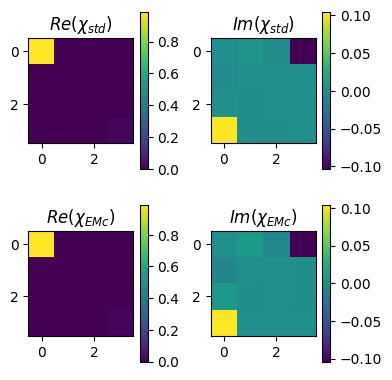

In [30]:
# the \chi matrix
zlist =[np.real(chi_pred),np.imag(chi_pred),np.real(chi_EM_c),np.imag(chi_EM_c)]
titlist = [r'$Re(\chi_{std})$',r'$Im(\chi_{std})$',r'$Re(\chi_{EMc})$',r'$Im(\chi_{EMc})$']
# print(np.abs(chi_pred-chi_EM_c))
plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(zlist[i])
    plt.colorbar()
    plt.title(titlist[i])
plt.tight_layout()



Text(0, 0.5, '$F(\\rho_{i},\\bar{\\rho_i})$')

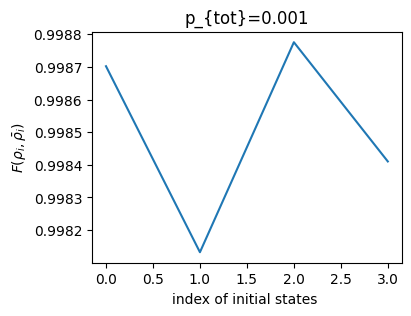

In [31]:
# the fidelty between the ideal and revised input states for a given error rate 
Flist = [get_chiF(rho_in_noisy[i].full(),qpt0.rho_in_idea[i].full()) for i in range(len(rho_in_noisy))]
plt.figure(figsize=(4,3))
plt.plot(Flist)
plt.title('p_{tot}='+str(p_tot))
plt.xlabel('index of initial states ')
plt.ylabel(r'$F(\rho_{i},\bar{\rho_i})$')